## 20 genes

In [1]:
xenium.genes <- read.csv("/camp/home/hungm/scratch/hungm/matthew/MH_Hackathon/2025_CRUK/data/TCGA2/4_xenium/xenium20.txt", header = F)[[1]]

In [2]:
xenium.genes

[1] "ATG10"    "CUL4A"    "DAB1"     "DAOA"     "DKK1"     "EFNB2"   
 [7] "GCKR"     "HSPA6"    "INSL4"    "KCNK2"    "MMP8"     "NCSTN"   
[13] "NR5A1"    "NTSR1"    "OPRM1"    "PARP1"    "PBX1"     "RILPL2"  
[19] "SCG5"     "TMEM106B"

In [5]:
# processed on NEMO so far
set.seed(42)
library(tidyverse)
library(SummarizedExperiment)
library(readxl)
library(glmnet)
library(survival)
setwd("/camp/home/hungm/scratch/hungm/matthew/MH_Hackathon/2025_CRUK/data/TCGA2/0_raw")
source("/camp/home/hungm/working/Matthew/library/R/functions/coxph/coxph.R")

In [6]:
gs <- list(xenium20 = xenium.genes)
write.gmt <- function(genelist, file) {
  file_conn <- file(file, open = "wt")
  for (set_name in names(genelist)) {
    line <- c(set_name, set_name, genelist[[set_name]])
    writeLines(paste(line, collapse = "\t"), file_conn)}
  close(file_conn)}

write.gmt(gs, "../4_xenium/xenium20.gmt")

In [7]:
library(ssGSEA2)

In [8]:
res = run_ssGSEA2(
    "../1_processed/TCGA_lung_gex.gct",
    output.prefix = "ssGSEA",
    gene.set.databases = "../4_xenium/xenium20.gmt",
    output.directory = "../4_xenium/ssGSEA_validation/",
    sample.norm.type = "none", 
    weight = 0.75, 
    correl.type = "rank", 
    statistic = "area.under.RES",
    output.score.type = "NES", 
    nperm = 1000, 
    min.overlap = 2, 
    extended.output = F, 
    global.fdr = FALSE,
    log.file = "../4_xenium/ssGSEA_validation/ssGSEA.log")

parsing as GCT v1.2

../1_processed/TCGA_lung_gex.gct 20501 rows, 1017 cols, 0 row descriptors, 0 col descriptors



xenium20   100 %
main loop: 33.76148 
Saving file to  ../4_xenium/ssGSEA_validation//signature_gct/xenium20_n1017x20.gct 
Dimensions of matrix: [20x1017]
Setting precision to 4
Saved.
[1] "Total gene sets: 1"
[1] "Unique gene sets: 1"
Saving file to  ../4_xenium/ssGSEA_validation//ssGSEA-scores.gct 
Dimensions of matrix: [1x1017]
Setting precision to 4
Saved.
Saving file to  ../4_xenium/ssGSEA_validation//ssGSEA-pvalues.gct 
Dimensions of matrix: [1x1017]
Setting precision to 4
Saved.
Saving file to  ../4_xenium/ssGSEA_validation//ssGSEA-fdr-pvalues.gct 
Dimensions of matrix: [1x1017]
Setting precision to 4
Saved.
Saving file to  ../4_xenium/ssGSEA_validation//ssGSEA-combined.gct 
Dimensions of matrix: [1x1017]
Setting precision to 4
Saved.


## Combine ssGSEA with survival

In [15]:
ssgsea <- read.csv("../3_classification/ssGSEA-scores.gct", row.names = 1, skip = 2, sep = "\t")[,-c(1,2)]
colnames(ssgsea) <- gsub("\\.", "-", colnames(ssgsea))
ssgsea <- t(ssgsea)
head(ssgsea)

,lung,LUSC,LUAD
TCGA-05-4244,8.5002,6.2464,5.3847
TCGA-05-4249,7.4015,6.3764,5.0068
TCGA-05-4250,8.0044,6.8932,5.9218
TCGA-05-4382,7.6315,6.2107,5.2858
TCGA-05-4384,8.0361,6.3106,6.1525
TCGA-05-4389,7.8553,6.4251,5.6181


In [16]:
xenium20 <- read.csv("../4_xenium/ssGSEA_validation/ssGSEA-scores.gct", row.names = 1, skip = 2, sep = "\t")[,-c(1,2)]
colnames(xenium20) <- gsub("\\.", "-", colnames(xenium20))
xenium20 <- t(xenium20)
head(xenium20)

,xenium20
TCGA-05-4244,3.9846
TCGA-05-4249,3.5907
TCGA-05-4250,4.1152
TCGA-05-4382,3.8769
TCGA-05-4384,3.9146
TCGA-05-4389,3.8547


In [17]:
# read gene expression
gex <- read.csv("../1_processed/TCGA_lung_gex.csv", row.names = 1)
colnames(gex) <- gsub("\\.", "-", colnames(gex))
gex[1:5, 1:5]

,TCGA-05-4244,TCGA-05-4249,TCGA-05-4250,TCGA-05-4382,TCGA-05-4384
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,26.0302,120.1350,50.8597,145.904,127.3670
A1CF,0.0000,0.3220,0.0000,0.000,0.0000
A2BP1,1.7454,1.6098,0.0000,0.000,0.0000
A2LD1,135.5020,89.0629,151.1330,112.069,87.5748
A2M,9844.7900,25712.7000,16943.6000,23326.300,48314.6000


In [18]:
# read survival data
surv <- read.csv("../1_processed/TCGA_lung_survival.csv", row.names = 1)
colnames(surv) <- gsub("\\.", "_", colnames(surv))

# remove time < 0 or NA
surv <- surv %>% filter(!is.na(PFI_time_1))
surv$PFI_time_1 <- as.numeric(surv$PFI_time_1)/365.25
surv$PFI_1 <- as.numeric(surv$PFI_1)

# set max PFI to 10 years
surv$PFI_1 <- ifelse(surv$PFI_time_1 > 10, 0, surv$PFI_1)
surv$PFI_time_1 <- ifelse(surv$PFI_time_1 > 10, 10, surv$PFI_time_1)
surv <- surv[surv$PFI_time_1 > 0, ]

# create survival object
surv$PFI <- Surv(surv$PFI_time_1, surv$PFI_1)
surv <- cbind(surv, ssgsea[rownames(surv),])
surv <- cbind(surv, xenium20[rownames(surv),, drop = F])

# merge expression with survival data
xenium20exp <- scale(t(gex)[rownames(surv),gs[[1]]])
surv <- cbind(surv, xenium20exp)

head(surv)

,type,PFI_1,PFI_time_1,PFI_2,PFI_time_2,PFS,PFS_time,DSS_cr,DSS_time_cr,DFI_cr,⋯,MMP8,NCSTN,NR5A1,NTSR1,OPRM1,PARP1,PBX1,RILPL2,SCG5,TMEM106B
,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-05-4249,LUAD,0,4.1697467,0,1523,0,1523,0,1523,NA,⋯,-0.08783663,0.4951856,-0.14335876,-0.10751199,-0.1012157,1.0723559,-0.6294784,-0.06100895,-0.25605393,-0.19812889
TCGA-05-4250,LUAD,0,0.3312799,0,121,1,121,NA,121,NA,⋯,-0.28991267,-0.5851363,-0.14070875,-0.06453740,-0.1012157,-0.6689259,-0.8526004,-0.45319223,1.02220044,0.81105108
TCGA-05-4382,LUAD,1,0.9144422,1,334,1,334,0,607,1,⋯,0.98036290,2.1426275,-0.09064977,-0.05428312,0.2282981,-0.4721944,-0.5185958,0.06266203,0.06254723,1.34793936
TCGA-05-4384,LUAD,1,0.5010267,1,183,1,183,0,426,NA,⋯,0.16829559,0.9057056,-0.14596833,-0.10685010,0.9502542,-0.5934462,-0.2294542,-0.34025058,0.13034559,-0.06938389
TCGA-05-4389,LUAD,0,3.7481177,0,1369,0,1369,0,1369,NA,⋯,-0.32039621,1.0763723,-0.14799204,-0.10914289,-0.1012157,-0.1040168,-0.9009495,0.56662034,0.47124464,1.69444579
TCGA-05-4390,LUAD,1,1.0814511,NA,NA,1,395,0,1126,NA,⋯,1.07621775,-0.1573105,-0.13637465,0.08829672,-0.1012157,-0.4078074,-0.5433974,-1.26060748,0.06295134,0.21645937


In [19]:
surv.LUAD <- surv %>%
    filter(type == "LUAD") %>%
    mutate(
        LUAD = as.numeric(scale(LUAD)),
        xenium20 = as.numeric(scale(xenium20)))

In [20]:
lm_eqn <- function(df){
    m <- lm(y ~ x, df);
    eq <- substitute(italic(y) == a + b %.% italic(x)*","~~italic(r)^2~"="~r2, 
         list(a = format(unname(coef(m)[1]), digits = 2),
              b = format(unname(coef(m)[2]), digits = 2),
             r2 = format(summary(m)$r.squared, digits = 3)))
    as.character(as.expression(eq));
}

In [21]:
library(ggpmisc)

Loading required package: ggpp

Registered S3 methods overwritten by 'ggpp':
  method                  from   
  heightDetails.titleGrob ggplot2
  widthDetails.titleGrob  ggplot2


Attaching package: ‘ggpp’


The following objects are masked from ‘package:ggpubr’:

    as_npc, as_npcx, as_npcy


The following object is masked from ‘package:ggplot2’:

    annotate


Registered S3 method overwritten by 'ggpmisc':
  method                  from   
  as.character.polynomial polynom



In [35]:
class <- read.csv("../3_classification/TCGA_metastatic_classification.csv", row.names = 1)
surv.LUAD <- cbind(surv.LUAD, class[rownames(surv.LUAD),])

`geom_smooth()` using formula = 'y ~ x'


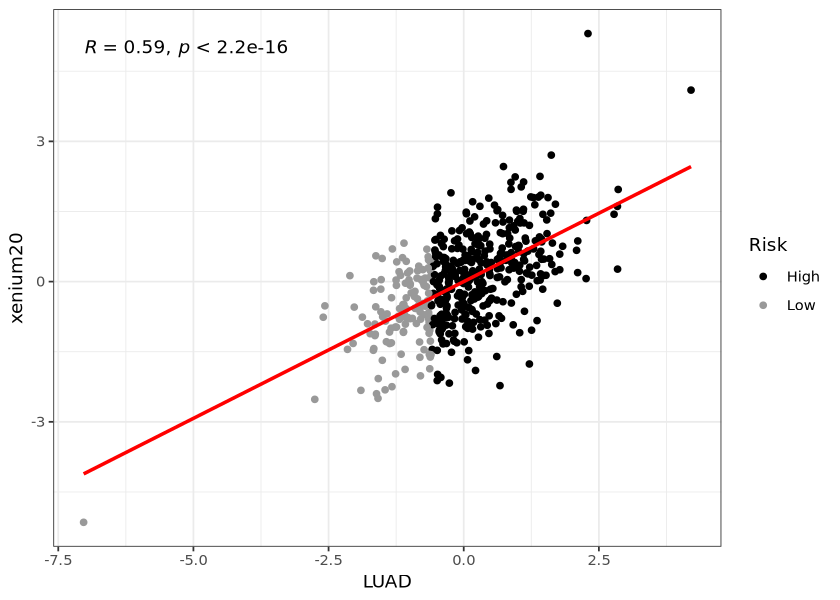

In [68]:
options(repr.plot.width=7, repr.plot.height=5)
surv.LUAD %>%
    #filter(LUAD > -5 & LUAD < 3) %>%
    #filter(xenium20 < 4) %>%
    mutate(risk = ifelse(LUAD_coxph == 1, "High", "Low")) %>%
    ggplot(aes(x = LUAD, y = xenium20)) +
    geom_point(aes(color = risk)) +
    stat_cor(method = "pearson") +
    geom_smooth(method = "lm", se = FALSE, color = "red") +
    scale_color_manual(values = c("black", "grey60")) +
    guides(color = guide_legend(title = "Risk")) +
    theme_bw()

`geom_smooth()` using formula = 'y ~ x'


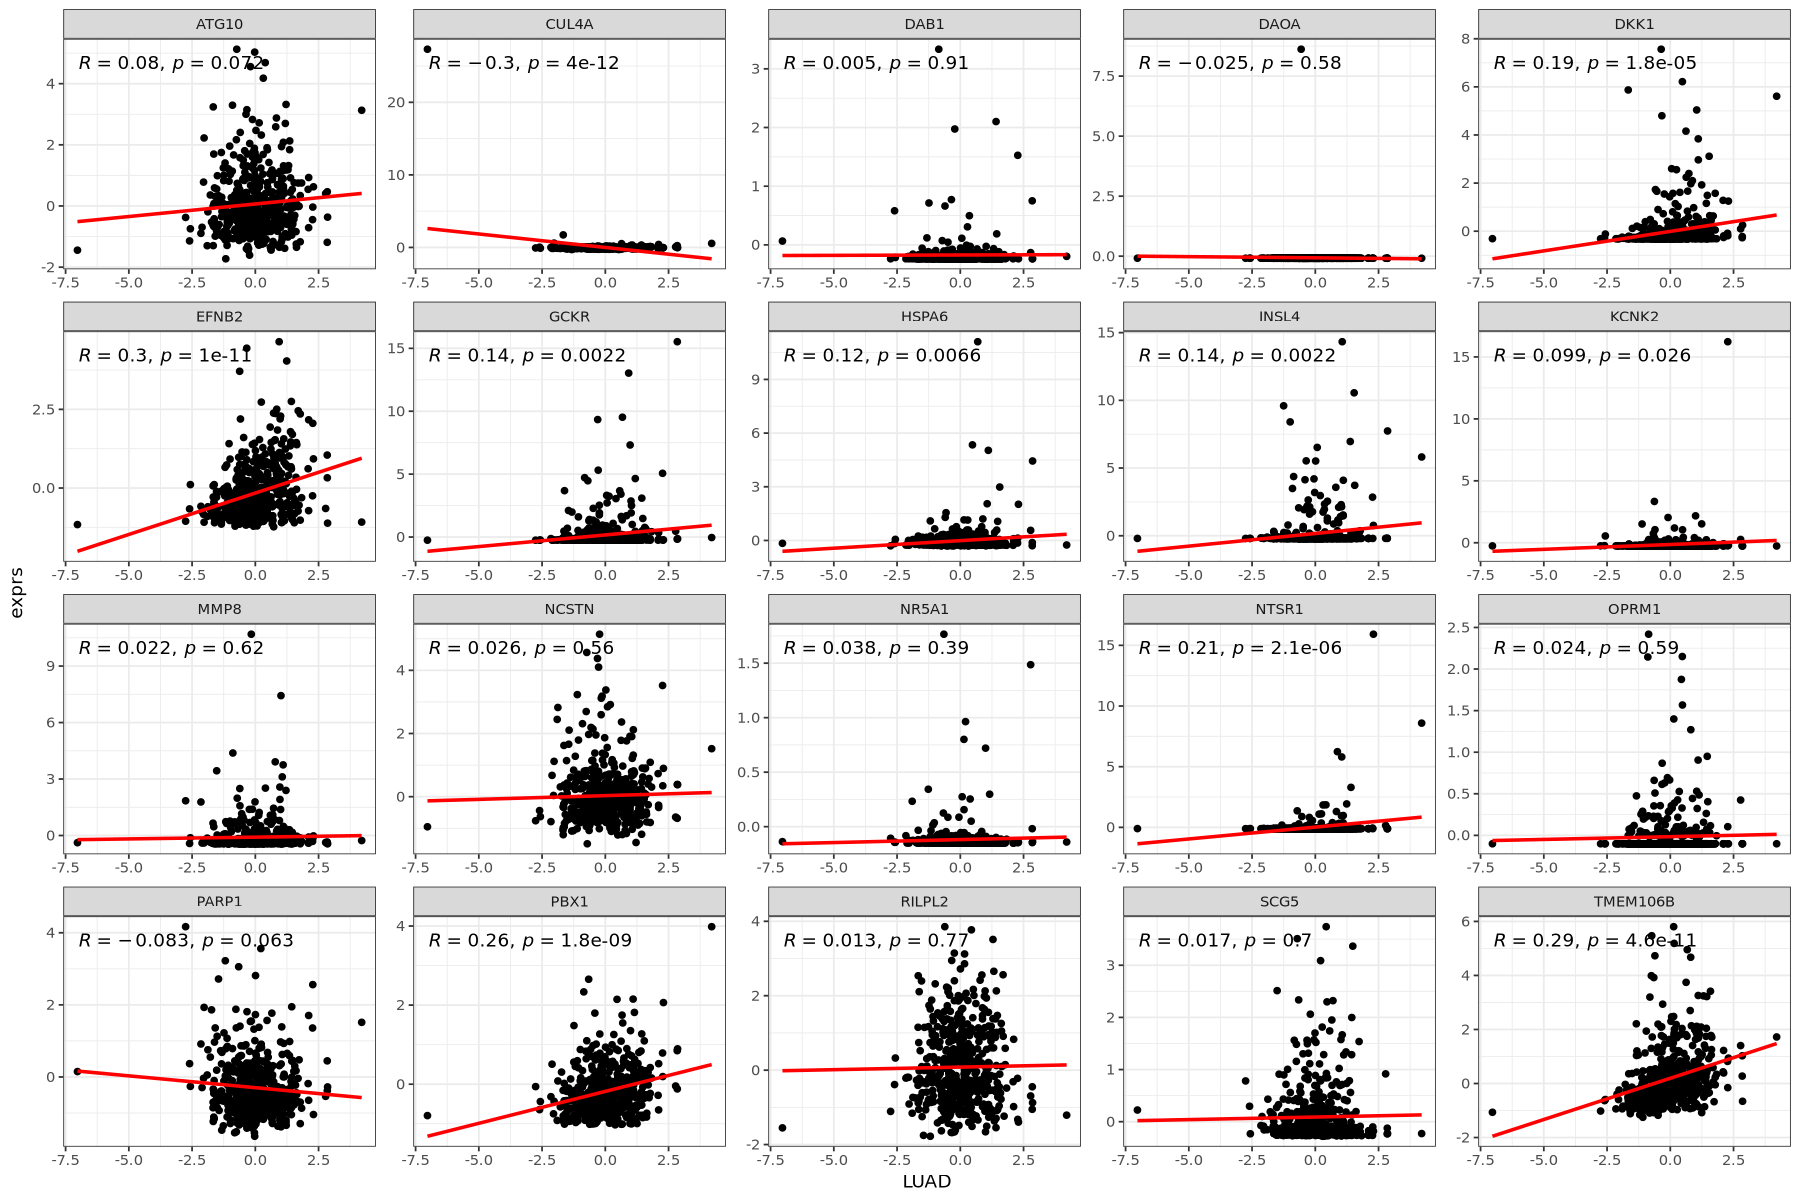

In [70]:
options(repr.plot.width=15, repr.plot.height=10)
surv.LUAD %>%
    select(c("LUAD", unname(gs[[1]]))) %>%
    pivot_longer(cols = unname(gs[[1]]), names_to = "xenium_genes", values_to = "exprs") %>%
    mutate(
        LUAD = as.numeric(LUAD),
        exprs = as.numeric(exprs)) %>%
    ggplot(aes(x = LUAD, y = exprs)) +
    facet_wrap(~xenium_genes, scales = "free") +
    geom_point() +
    stat_cor(method = "pearson") +
    geom_smooth(method = "lm", se = FALSE, color = "red") +
    theme_bw() 

In [25]:
find_coxph_cutoff <- function(df, column, survival, set_cutoff = NULL, covariates = NULL, interquartile = T){

    #split data at 200 intervals and find the cutoff with most significant difference in survival
    if(length(covariates) > 0){
        covariates_coxph <- paste0(" + ", paste0(covariates, collapse = " + "))
        print(paste0("set covariates ===> ", covariates_coxph))}
    else{
	    covariates_coxph <- ""}
    cutoff <- NULL

    if(interquartile){
        lower <- quantile(df[[column]])[[2]]
        upper <- quantile(df[[column]])[[4]]}
    else{
        lower <- min(df[[column]])
	upper <- max(df[[column]])}

    no <- nrow(df)

    for (split in seq(lower, upper, length.out = 200)) {
        df[["coxph"]] <- ifelse(df[[column]] > split, "High", "Low")
        df[["coxph"]] <- factor(df[["coxph"]], levels = c("Low", "High"))
        remove <- any(table(df$coxph) < no / 20)
        if (remove) {
            next
        }
        surv.cox <- coxph(as.formula(paste0(survival, " ~ coxph", covariates_coxph)), data = df)
        
        # Extract HR and p-value
        hr <- round(exp(coef(surv.cox))[1], 3)  # Hazard Ratio
        logr <- round(summary(surv.cox)$coefficients[1, "Pr(>|z|)"], 3)  # p-value
        
        cutoff <- rbind(cutoff, c(split, hr, logr))
        colnames(cutoff) <- c("cutoff", "HR", "logr")
    }


    # use most significant cutoff to split data in "High" & "Low" groups
    cutoff <- as.data.frame(cutoff) %>% arrange(logr)
    if(length(set_cutoff) == 0){
        threshold <- cutoff$cutoff[1]}
    else if(length(set_cutoff) == 1){
        threshold <- set_cutoff}
    else{
	error("set_cutoff should be set to length of 1")}
    print(paste0("for <", column, ">, cutoff is set at  ===> ", threshold))
    df[[paste0(column, "_coxph")]] <- ifelse(df[[column]] > paste0(threshold), "High", "Low")
    df[[paste0(column, "_coxph")]] <- factor(df[[paste0(column, "_coxph")]], levels=c("Low", "High"))
    df$coxph <- NULL
    return(df)
}

In [26]:
surv.LUAD <- find_coxph_cutoff(df = surv.LUAD, column = "xenium20", survival = "PFI", covariate = NULL, interquartile = T)

[1] "for <xenium20>, cutoff is set at  ===> 0.561976140789476"


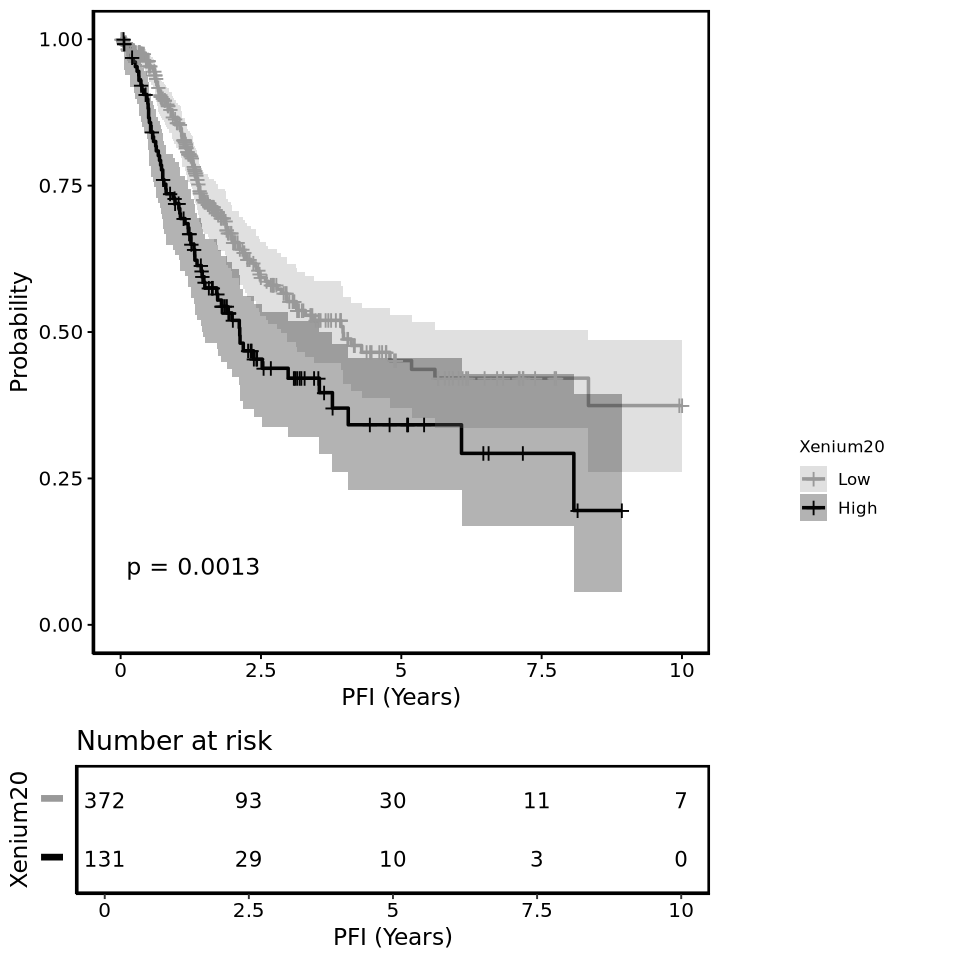

In [46]:
options(repr.plot.width=8, repr.plot.height=8)
plot_survival <- function(df, column, survival, palette = NULL, ...){
    if(!(column %in% colnames(df))){
	message(paste0("<", column, "> not found in dataframe. Skipped"))
	next}

    suppressMessages({
    b <- as.formula(paste0(survival, "~", column))
    fit <- eval(substitute(survfit(b, data = df, conf.type = "log-log"), list(b = b)))

    if(length(names(fit$strata)) > 1){
        names(fit$strata) <- gsub(".*=", "", names(fit$strata))
        kmplot <- ggsurvplot(
            fit,
            data = df,
            palette = palette,
            risk.table = T,
            pval = T,
            risk.table.y.text.col = T,
            risk.table.y.text = F,
            legend = "right",
            ...)
            }
    else{
            kmplot <- NULL
    }})
    kmplot[[1]] <- kmplot[[1]] + theme(panel.border = element_rect(colour = "black", fill=NA, size=1.5))
    kmplot[[2]] <- kmplot[[2]] + theme(panel.border = element_rect(colour = "black", fill=NA, size=1.5))
    return(kmplot)}

p <- plot_survival(surv.LUAD, column = "xenium20_coxph", legend.title = "Xenium20", survival = "PFI", palette = c("grey60", "grey1"), conf.int = T, ylim = c(0, 1), ylab = "Probability", xlab = "PFI (Years)", pval.coord = c(0.1, 0.1))
p